# Телеком - прогнозирование оттока клиентов оператора связи

# 1. Описание

Телеком - прогнозирование оттока клиентов оператора связи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## 1.2 Описание услуг

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## 1.2 Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# План работ

1. Описание

1.1 Описание услуг

1.2 Описание данных

2. Загрузка данных и предварительный анализ

2.1 Загрузка данных и библиотек

2.2 Предварительный анализ данных

2.3 Объеденение данных и генерация признаков

3. Исследовательский анализ данных и подготовка данных для обучения моделей

3.1 Исследовательский анализ данных

3.2 Подготовка данных для обучения моделей

3.3 Обучение моделей

3.4 Проверка на тестовой выборке

4. Вывод


# 2. Загрузка данных и предварительный анализ

## 2.1 Загрузка данных и библиотек

In [ ]:
!pip install CatBoost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.5 MB/s eta 0:00:00


In [ ]:
!pip install -U -q scikit-learn
!pip install -U -q matplotlib
!pip install -U -q seaborn

In [ ]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from numpy.random import RandomState
from tqdm import notebook
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
import re
from matplotlib import cm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
# чтение файла данных в датафрейм из папки по умолчанию и из рабочей директории
# в качестве индекса выберем  customerID, это удобно для проведения дальнейших анализов и операций с данными
try:
    contract = pd.read_csv('/content/contract_new.csv', index_col='customerID')
    internet = pd.read_csv('/content/internet_new.csv', index_col='customerID')
    personal = pd.read_csv('/content/personal_new.csv', index_col='customerID')
    phone = pd.read_csv('/content/phone_new.csv', index_col='customerID')
except:
    contract = pd.read_csv('/datasets/contract_new.csv', index_col='customerID')
    internet = pd.read_csv('/datasets/internet_new.csv', index_col='customerID')
    personal = pd.read_csv('/datasets/personal_new.csv', index_col='customerID')
    phone = pd.read_csv('/datasets/phone_new.csv', index_col='customerID')

## 2.1 Предварительный анализ данных

In [ ]:
# В работе 4 сета данных. Ускорим просмотр основной информации через функцию
def info(data):
    display(data.head())
    display(data.describe().T)
    print('      ')
    print('Информация о пропусках и типах данных')
    print('      ')
    print()
    display(data.info())
    print('      ')
    print()

In [ ]:
info(contract)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


      
Информация о пропусках и типах данных
      

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


None

Необходимо будет изменить тип данных для признаков BeginDate, EndDate, TotalCharges

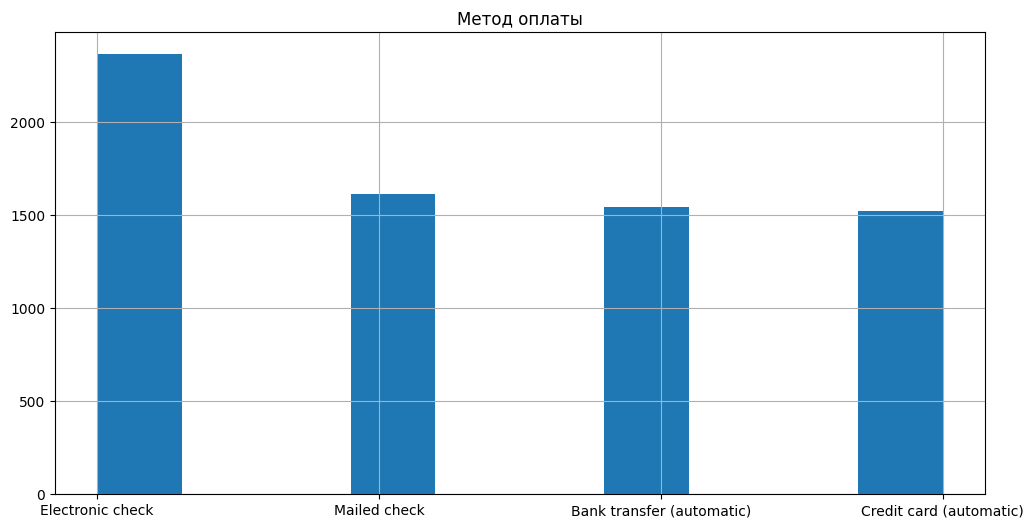

In [ ]:
contract['PaymentMethod'].hist(figsize=(12,6))
plt.title('Метод оплаты');

Электронную оплату выбирают чаше всего, так как это самый удобный способ оплаты.

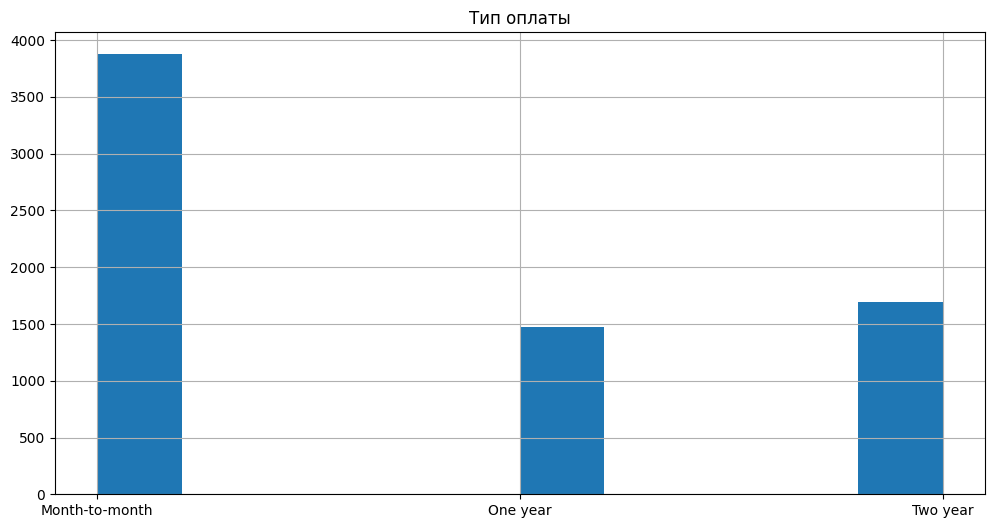

In [ ]:
contract['Type'].hist(figsize=(12,6))
plt.title('Тип оплаты');

Большинство клиентов предпочитают ежемесячную оплату, однако статистика показывает, что количество клиентов, которые выбирают оплату на два года, превышает число тех, кто выбирает годовую оплату. Вероятно, это объясняется более выгодными условиями, предоставляемыми для клиентов, которые оплачивают за два года.

<Axes: >

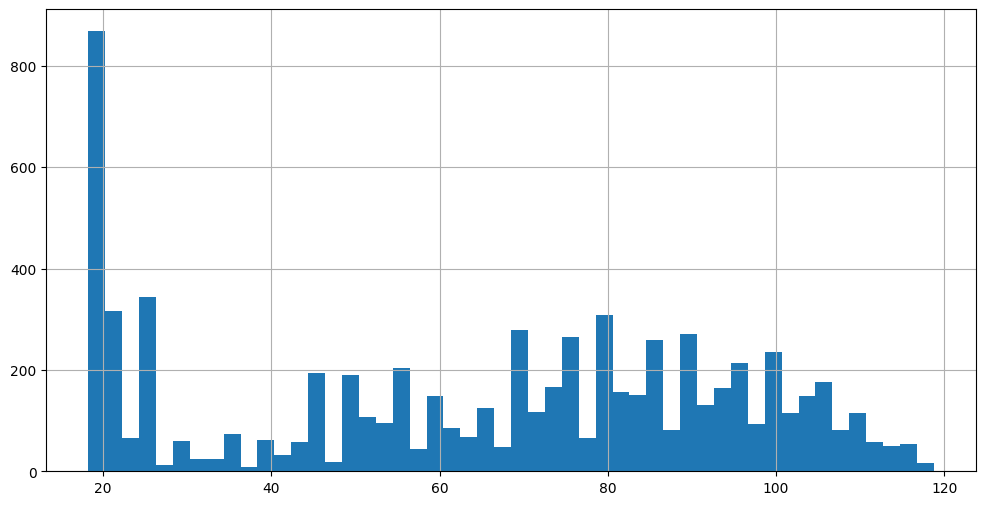

In [ ]:
contract['MonthlyCharges'].hist(bins=50, figsize=(12,6))

Данные выглядят необычно: присутствует ряд значений, которые явно выбиваются из общей картины и превышают 20. Кроме того, этот признак содержит огромное количество различных значений, что может затруднять анализ данных. Необходимо более детально изучить этот признак и возможно применить методы обработки/очистки данных для устранения выбросов и уменьшения числа уникальных значений.

Вывод :

Анализ датасета показал, что необходимо провести предобработку данных. В частности, следует изменить тип данных в колонках BeginDate и EndDate на datetime, а также в колонке TotalCharges - на float.

Кроме того, целесообразно более детально изучить ежемесячную оплату, чтобы выяснить причины выбросов значений и проанализировать распределение данного признака. Это позволит провести более точный анализ данных и сделать выводы о возможных взаимосвязях между признаками.

In [ ]:
info(internet)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


,count,unique,top,freq
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


      
Информация о пропусках и типах данных
      

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


None

Вывод :

В данном наборе данных отсутствуют все пользователи, что логично, так как не все люди подключают услуги у одного и того же оператора мобильной связи и домашнего интернета. Однако в следующем наборе данных ситуация с отсутствием какого-то количества пользователей может повториться.

Также в данных наблюдается присутствие бинарной классификации внутри каждого признака. Для более детального анализа данных необходимо рассмотреть каждый признак отдельно и проанализировать возможные взаимосвязи между ними. Это позволит провести более точный и полный анализ данных, выявить скрытые закономерности и сделать выводы о ключевых факторах, влияющих на поведение клиентов.

Text(0.5, 1.0, 'Тип интернет подключения')

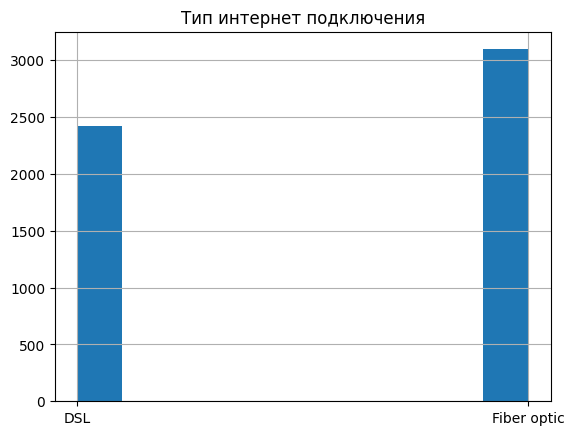

In [ ]:
internet['InternetService'].hist()
plt.title('Тип интернет подключения')

Text(0.5, 1.0, 'Блокировка небезопасных сайтов')

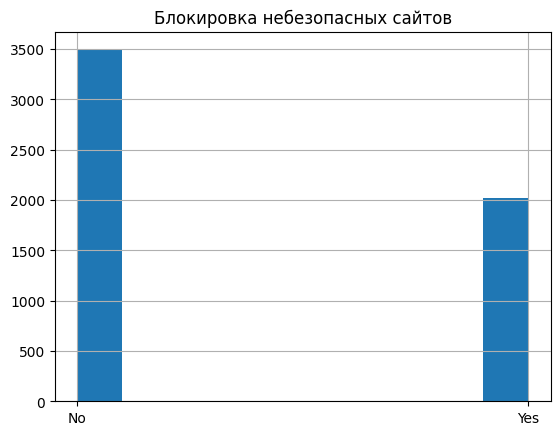

In [ ]:
internet['OnlineSecurity'].hist()
plt.title('Блокировка небезопасных сайтов')

Text(0.5, 1.0, 'Облачное хранилище')

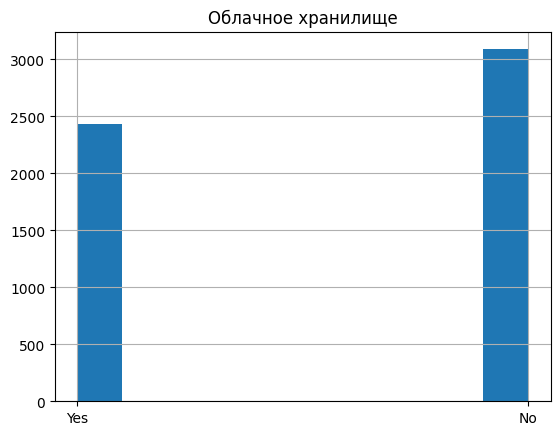

In [ ]:
internet['OnlineBackup'].hist()
plt.title('Облачное хранилище')

Text(0.5, 1.0, 'Интернет-безопасность')

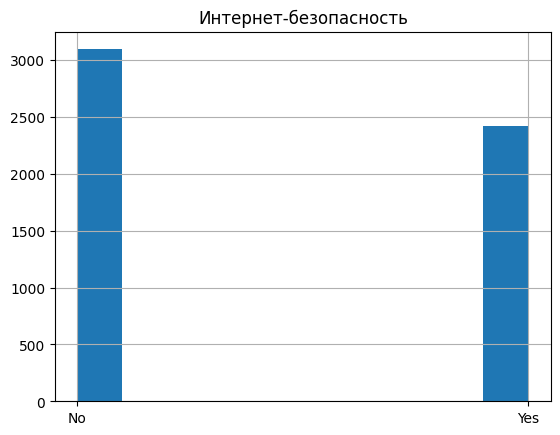

In [ ]:
internet['DeviceProtection'].hist()
plt.title('Интернет-безопасность')

Text(0.5, 1.0, 'Выделенная линия технической поддержки')

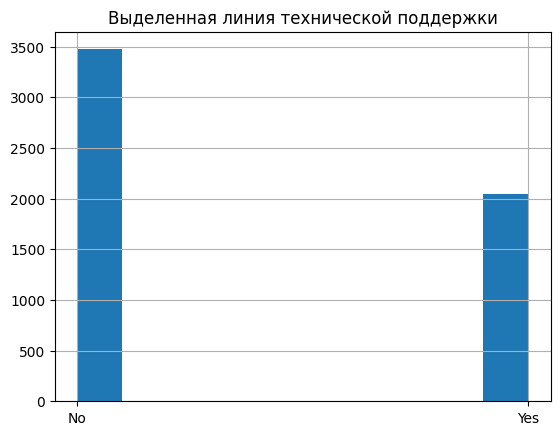

In [ ]:
internet['TechSupport'].hist()
plt.title('Выделенная линия технической поддержки')

Text(0.5, 1.0, 'Стриминговое телевидение')

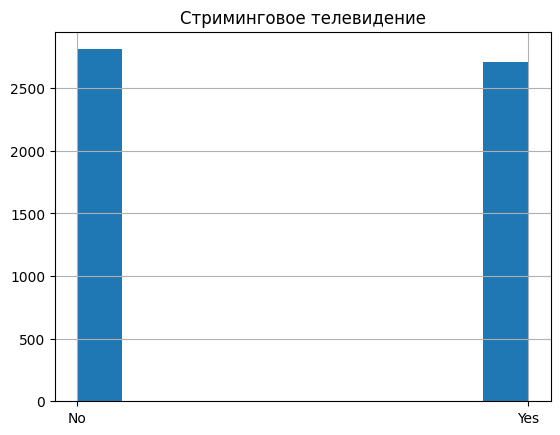

In [ ]:
internet['StreamingTV'].hist()
plt.title('Стриминговое телевидение')

Text(0.5, 1.0, 'Каталог фильмов')

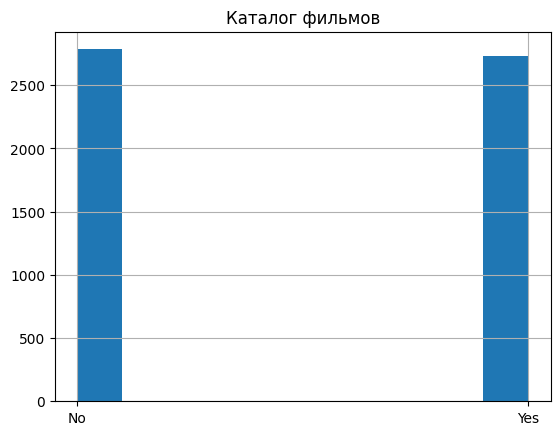

In [ ]:
internet['StreamingMovies'].hist()
plt.title('Каталог фильмов')

Вывод :

Анализ данных показал, что большинство пользователей имеют подключение к оптоволоконному кабелю, в то время как DSL обладает меньшей скоростью и используется обычно там, где нет возможности провести оптоволоконный кабель, например, в частных домах.

Отказ от дополнительных услуг является распространенной практикой среди пользователей. Это объясняется тем, что у большинства пользователей уже есть некоторые антивирусы или они предпочитают использовать другие подобные сервисы. Возможно, также есть пользователи, которые просто не знают, для чего нужны эти дополнительные услуги.

Ситуация с подключением стриминговых сервисов немного отличается - число пользователей, которые подключают эти сервисы, примерно равно числу тех, кто не подключает их. Это можно объяснить тем, что телевизионное подключение обычно сопровождается интернет-подключением, а у некоторых пользователей телевизор может быть не нужен, поэтому они пользуются только интернетом.

In [ ]:
info(personal)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0


      
Информация о пропусках и типах данных
      

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


None

В данных присутсвуюет каждый пользователь

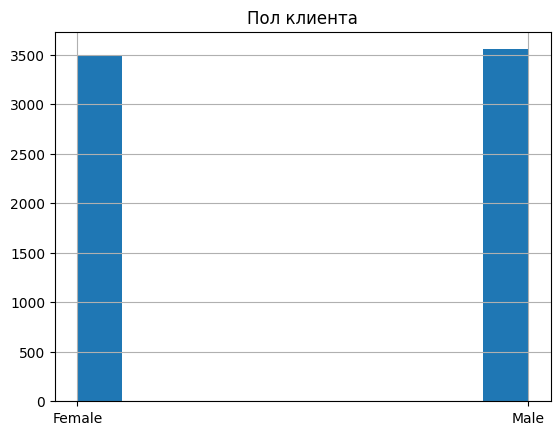

In [ ]:
personal['gender'].hist()
plt.title('Пол клиента');

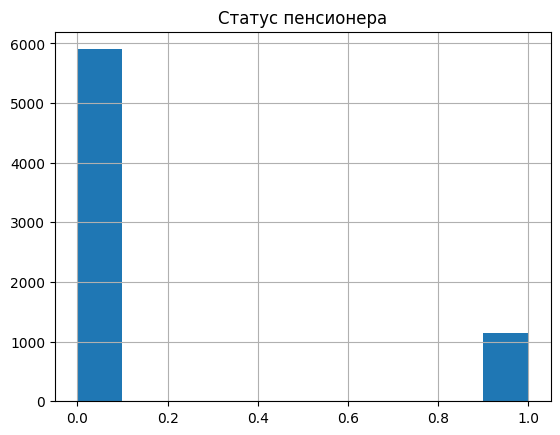

In [ ]:
personal['SeniorCitizen'].hist()
plt.title('Статус пенсионера');

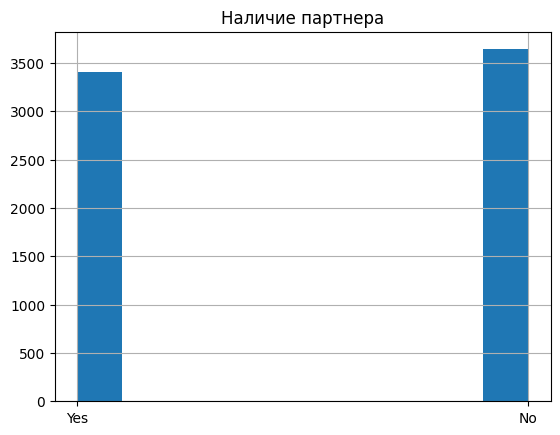

In [ ]:
personal['Partner'].hist()
plt.title('Наличие партнера');

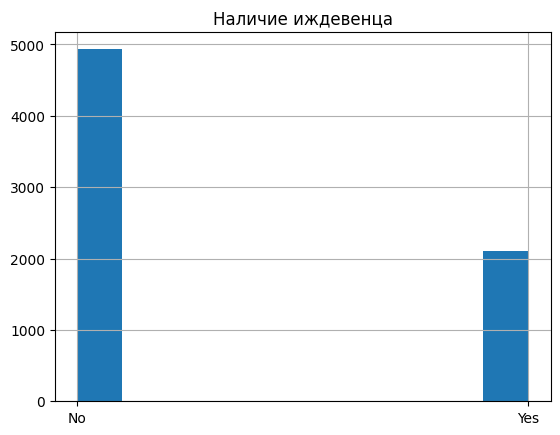

In [ ]:
personal['Dependents'].hist()
plt.title('Наличие иждевенца');

Вывод :

Проведенный анализ признака personal позволил выявить следующие закономерности: разделение по полу и наличию партнера не являются значимыми, в то время как наличие иждивенцев и статус пенсионеров оказывает существенное влияние на использование услуг.

Так, клиенты, имеющие большое количество иждивенцев, а также пенсионеры, меньше всего пользуются услугами. Это можно объяснить тем, что у них часто нет необходимости в более широком спектре услуг, либо у них ограниченный доход.

In [ ]:
info(phone)

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


,count,unique,top,freq
MultipleLines,6361,2,No,3390


      
Информация о пропусках и типах данных
      

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


None

датасет содержит информацию о пользователях у которых подключена возможности ведения параллельных линий во время звонка, их меньше чем базовое колличестов пользователей 7043

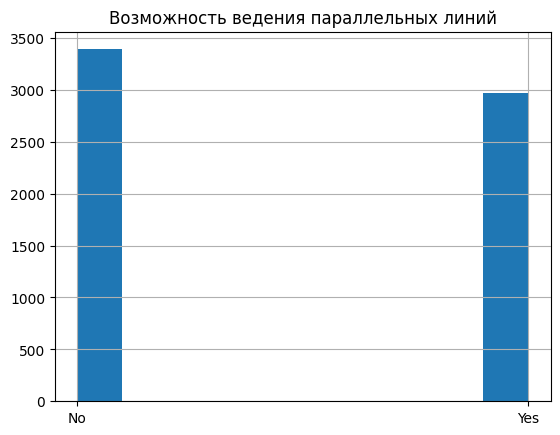

In [ ]:
phone['MultipleLines'].hist()
plt.title('Возможность ведения параллельных линий');

Вывод :

Не большой перевес, в сторону пользователей у которых отсутсвует возможность ведения параллельных линий.

## 2.2 Объеденение данных и генерация признаков

Добавление признака Churn

Добавим колонку с целевым признаком, отражающий факт ухода клиента.

In [ ]:
contract['Churn'] = (contract['EndDate'] != 'No').astype(int)

In [ ]:
contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0


Перобразуем тип данных у признаков BeginDate, EndDate, TotalCharges

In [ ]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

В признаке EndDate значение "No" заполним финальной датой датасета и поменяем тип данных.



In [ ]:
contract['EndDate'] = contract['EndDate'].where(contract['EndDate'] != 'No', '2020-02-01')

contract['EndDate'] = pd.to_datetime(contract['EndDate'])

Перед тем как продолжить измененять тип данных, заполним пропуски в признаке TotalCharges

In [ ]:
contract.query('TotalCharges ==  " "')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0


In [ ]:
contract.loc[contract['TotalCharges'] == " ", 'TotalCharges'] = 0

In [ ]:
# Проверим результат
contract.query('TotalCharges ==  " "')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,


In [ ]:
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

In [ ]:
info(contract)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2115.312885,2112.742814,0.00,436.75,1343.35,3236.69,9221.38
Churn,7043.0,0.156325,0.363189,0.00,0.00,0.00,0.00,1.00


      
Информация о пропусках и типах данных
      

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Churn             7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 495.2+ KB


None

Добавление признаков и объеденение данных

In [ ]:
data = contract.copy()

Создадим Period

Выделим признак, какой период (в днях) пользователь пользовался услугами заказчика на момент 2020-02-01.

In [ ]:
data['Period'] = (data['EndDate'] - data['BeginDate']).dt.days

In [ ]:
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Period
customerID,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


В таблицы internet и phone добавим по признаку, что бы при собирании одного датасета, у нас были пометки у пользователей кто какими услугами пользуется.

In [ ]:
internet['Internet'] = 1
phone['Phone'] = 1

In [ ]:
data = data.join(personal)
data = data.join(internet)
data = data.join(phone)

Заполним образовавшиеся пропуски

In [ ]:
data = data.fillna('No')

In [ ]:
data.isna().mean()

BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
Period              0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Internet            0.0
MultipleLines       0.0
Phone               0.0
dtype: float64

In [ ]:
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Period,gender,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,...,DSL,No,Yes,No,No,No,No,1.0,No,No
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,...,DSL,Yes,No,Yes,No,No,No,1.0,No,1.0
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,...,DSL,Yes,Yes,No,No,No,No,1.0,No,1.0
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,...,DSL,Yes,No,Yes,Yes,No,No,1.0,No,No
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,...,Fiber optic,No,No,No,No,No,No,1.0,No,1.0


Датасет готов для исследовальского анализа.

# 3. Исследовательский анализ данных и подготовка данных для обучения моделей

## 3.1 Исследовательский анализ данных

Распределение целевого признака

Посмотрим расспределение классов целевого признака

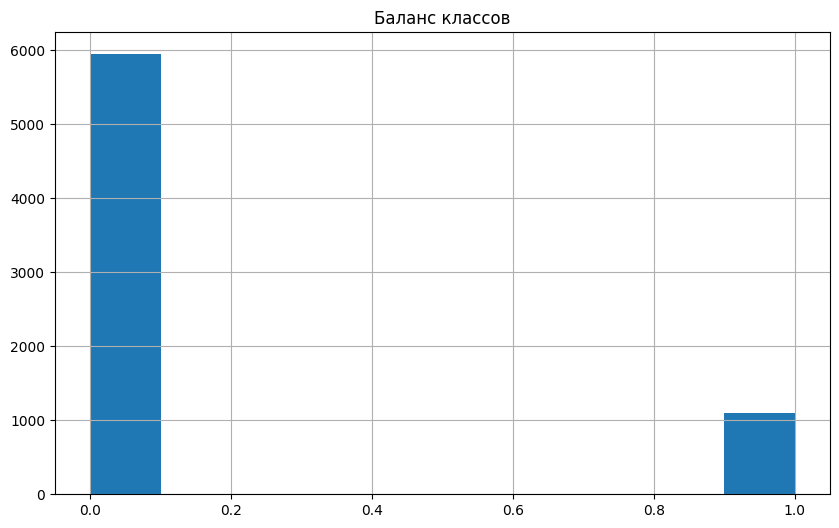

In [ ]:
data['Churn'].hist(figsize=(10,6))
plt.title('Баланс классов');

На графике наблюдается значительный перевес в пользу пользователей, которые продолжают пользоваться услугами заказчика. Это может свидетельствовать о высокой лояльности этих клиентов и качестве услуг, предоставляемых компанией.

Ежемесечные платежи

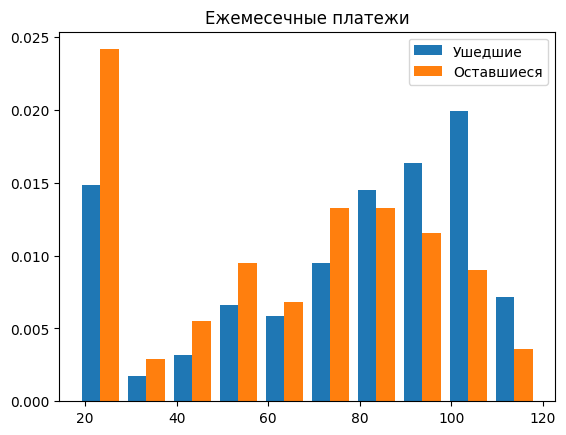

In [ ]:
plt.hist([data[data.Churn == 1].MonthlyCharges, data[data.Churn == 0].MonthlyCharges], label=['Ушедшие', 'Оставшиеся'], density=True);
plt.legend();
plt.title('Ежемесечные платежи');
plt.show();

Плотность ушедших клиентов на графике действительно выше для тех, у кого ежемесячный платеж составляет от 70 до 100. Это может быть связано с тем, что эти клиенты имеют больший выбор и могут перейти к другому провайдеру, если не удовлетворены текущим качеством услуг или ценами. Кроме того, более дорогие планы часто связаны с более высокими ожиданиями со стороны клиентов, и если провайдер не может достичь этих ожиданий, клиенты могут принять решение об уходе.

Распределение услуг

Взглянем какие клиенты заказчика чаше выбирают услуги.

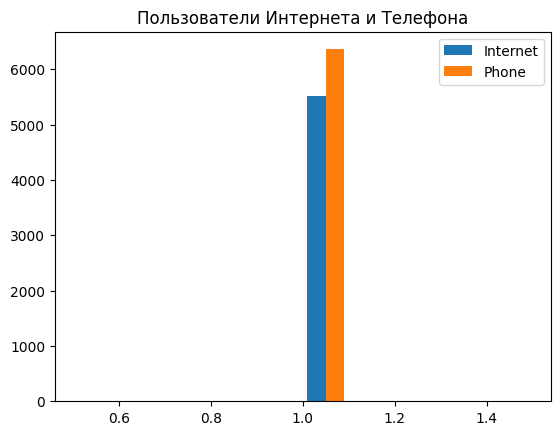

In [ ]:
plt.hist([data[data.Internet == 1].Internet, data[data.Phone == 1].Phone], label=['Internet', 'Phone']);
plt.legend();
plt.title('Пользователи Интернета и Телефона');
plt.show();

Заказчик в первую очередь является телефонным оператором, предоставляющим услуги связи. Однако он также выступает интернет-провайдером, предлагая своим клиентам доступ в сеть Интернет.

Распределение платежей
Взглянем на распределение ежемесячных платежей

<Axes: >

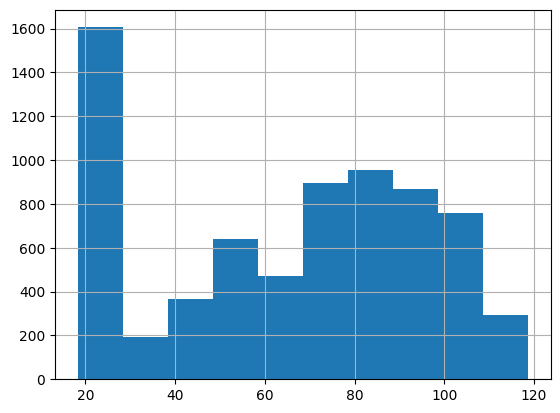

In [ ]:
data['MonthlyCharges'].hist()

Видно большое колличество людей которые платят меньше 30 На графике заметно большое количество людей, которые платят менее 30 за услуги телефонного оператора. Возможно, это связано с тем, что эти клиенты используют только базовые услуги связи, такие как звонки и SMS-сообщения, без необходимости использования дополнительных опций или доступа в Интернет.

Выделим этих клиентов и посмотри на них поподробнее.

In [ ]:
low_charges = data.query('MonthlyCharges < 30')

In [ ]:
low_charges.sample(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Period,gender,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone
customerID,,,,,,,,,,,,,,,,,,,,,
5480-HPRRX,2019-10-01,2020-02-01,Month-to-month,No,Electronic check,25.30,111.32,0,123,Female,...,DSL,No,No,No,No,No,No,1.0,No,No
2181-TIDSV,2014-06-01,2020-02-01,Two year,Yes,Bank transfer (automatic),19.95,1370.17,0,2071,Male,...,No,No,No,No,No,No,No,No,No,1.0
9294-TDIPC,2019-09-01,2020-02-01,Month-to-month,No,Mailed check,20.20,101.00,0,153,Male,...,No,No,No,No,No,No,No,No,No,1.0
2819-GWENI,2017-10-01,2020-02-01,One year,No,Mailed check,19.90,590.63,0,853,Female,...,No,No,No,No,No,No,No,No,No,1.0
7817-OMJNA,2018-12-01,2020-02-01,One year,No,Bank transfer (automatic),20.40,299.88,0,427,Male,...,No,No,No,No,No,No,No,No,No,1.0


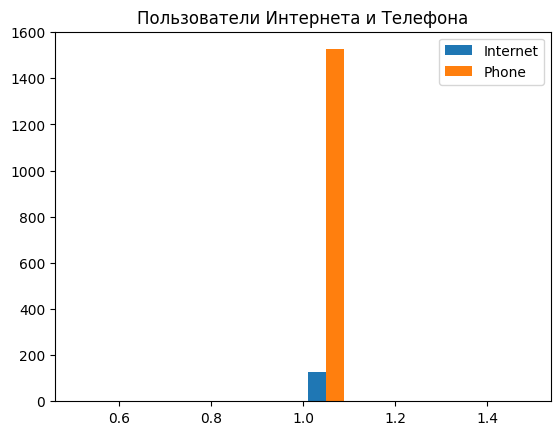

In [ ]:
plt.hist([low_charges[low_charges.Internet == 1].Internet, low_charges[low_charges.Phone == 1].Phone], label=['Internet', 'Phone']);
plt.legend();
plt.title('Пользователи Интернета и Телефона');
plt.show();

Можно сделать вывод, что основной круг клиентов заказчика - это пользователи мобильной связи.

In [ ]:
# Удаление столбца SeniorCitizen из датафрейма
data_without_senior = data.drop("SeniorCitizen", axis=1)

# Вычисление корреляций Пирсона между всеми парами признаков
corr_matrix = data_without_senior.corr(method="pearson")

<ipython-input-49-b0a22f0d8a58>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data_without_senior.corr(method="pearson")


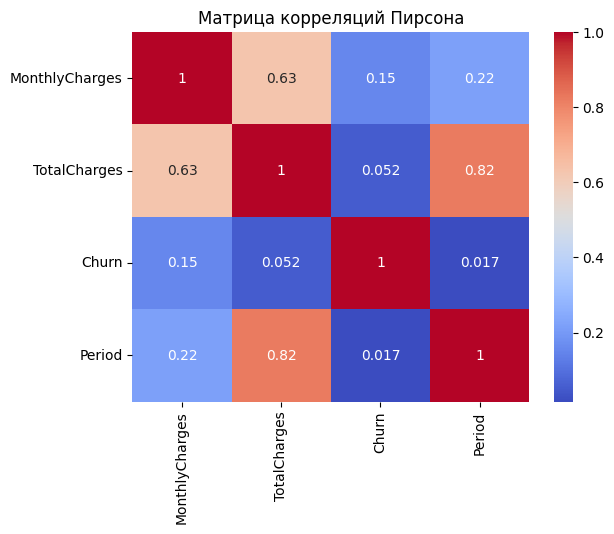

In [ ]:
# Визуализация матрицы корреляций
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Матрица корреляций Пирсона")
plt.show()

наблюдается корреляция 3-х признаков:

Period - какой срок клиент пользуеться услугами

MonthlyCharges - Размер ежемесечного платежа

TotalCharges - Общая сумма за весь срок пользования услугами заказчика

Корреляция между этими признаками может быть описана следующим образом: с увеличением периода пользования услугами увеличивается и общая сумма, которую клиент заплатил за весь период. Кроме того, часто можно заметить, что размер ежемесячного платежа также связан с общей суммой и периодом пользования услугами - например, если клиент платит больше каждый месяц, то общая сумма за весь период вероятно будет выше. Эти признаки можно использовать для анализа поведения клиентов и принятия решений в бизнесе.

## 3.2 Подготовка данных для обучения моделей

Сразу создадаим констатнту для фиксации random_state

In [ ]:
CONST = 220523

Получение разных датасетов
Создадим датасеты с разным колличеством параметров.

data_one - будет основным из него мы уберем только даты.

Из data_two уберем параметры связанные с доп.услугами

In [ ]:
data_one = data.drop(['BeginDate', 'EndDate'], axis=1)

data_two = data.drop(['BeginDate', 'EndDate', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'], axis=1)

In [ ]:
X = data_one.drop(['Churn'], axis = 1 )

X1 = data_two.drop(['Churn'], axis = 1)

y = data_one['Churn']

Визуализация
Визуализируем важность признаков.

Разбиение данных.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=CONST)

In [ ]:
# закодируем категориальные признаки в обучающей выборке
X_train = pd.get_dummies(X_train)

# затем закодируем категориальные признаки в тестовой выборке
X_test = pd.get_dummies(X_test)

# проверим совпадение списков признаков в обучающей и тестовой выборках
if set(X_train.columns) == set(X_test.columns):
    print("Списки признаков в обучающей и тестовой выборках совпадают")
else:
    print("Внимание: списки признаков в обучающей и тестовой выборках не совпадают")

Списки признаков в обучающей и тестовой выборках совпадают


Масштабируем признаки методом стандартизации.

In [ ]:
numeric = ['MonthlyCharges', 'TotalCharges', 'Period' ]
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

# 3.3 Обучение моделей

LogisticRegression

In [ ]:
model_log = LogisticRegression(random_state=CONST, solver='liblinear')
scores = cross_val_score(model_log, X_train, y_train, cv=5, scoring='roc_auc')

LR = scores.mean()
print('ROC-AUC: ', LR)

ROC-AUC:  0.758379942064001


RandomForestClassifier

In [ ]:
model_forest = RandomForestClassifier(random_state=CONST, n_estimators=100, max_depth=12)
scores = cross_val_score(model_forest, X_train, y_train, cv=5, scoring='roc_auc')

RF = scores.mean()
print('ROC-AUC: ', RF)

ROC-AUC:  0.8019847845892473


CatBoostClassifier

In [ ]:
# Определяем модель с начальными значениями гиперпараметров
model_cat = CatBoostClassifier(random_state=CONST, class_weights=[1, 10])

# Определяем набор значений гиперпараметров для поиска
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'iterations': [100, 200, 300]
}

# Выполняем поиск наилучших гиперпараметров с помощью кросс-валидации
grid_search = GridSearchCV(estimator=model_cat, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=100)
grid_search.fit(X_train, y_train)

# Сохраняем лучшее значение метрики в переменную CC
CatC = grid_search.best_score_

# Выводим наилучшее значение метрики и соответствующие гиперпараметры
print("Лучшее значение ROC-AUC:", CatC)
print("Лучшие гиперпараметры:", grid_search.best_params_)

Выходные данные были обрезаны до нескольких последних строк (5000).
33:	learn: 0.3680939	total: 327ms	remaining: 1.59s
34:	learn: 0.3653746	total: 336ms	remaining: 1.59s
35:	learn: 0.3637568	total: 347ms	remaining: 1.58s
36:	learn: 0.3615100	total: 358ms	remaining: 1.57s
37:	learn: 0.3606588	total: 363ms	remaining: 1.55s
38:	learn: 0.3574594	total: 374ms	remaining: 1.54s
39:	learn: 0.3541062	total: 384ms	remaining: 1.53s
40:	learn: 0.3509383	total: 402ms	remaining: 1.56s
41:	learn: 0.3506913	total: 405ms	remaining: 1.52s
42:	learn: 0.3461259	total: 416ms	remaining: 1.52s
43:	learn: 0.3426658	total: 425ms	remaining: 1.51s
44:	learn: 0.3397063	total: 435ms	remaining: 1.5s
45:	learn: 0.3353278	total: 445ms	remaining: 1.49s
46:	learn: 0.3320203	total: 456ms	remaining: 1.48s
47:	learn: 0.3289035	total: 466ms	remaining: 1.47s
48:	learn: 0.3276818	total: 475ms	remaining: 1.46s
49:	learn: 0.3276780	total: 477ms	remaining: 1.43s
50:	learn: 0.3249667	total: 486ms	remaining: 1.42s
51:	learn: 0.32

In [ ]:
conclusion = pd.DataFrame({'Model': ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier'], 'ROC-AUC':[LR, RF, CatC]})

In [ ]:
conclusion

,Model,ROC-AUC
0,LogisticRegression,0.758380
1,RandomForestClassifier,0.801985
2,CatBoostClassifier,0.870158


Лучший результат показала модель CatBoostClassifier - 0.87, в дальнейшем будем использовать catboost

Дисбаланс классов не проверяем так как ROC-AUC не чувствительна к дисбалансу классов

## 3.4 Проверка на тестовой выборке

In [ ]:
model_cat = CatBoostClassifier(random_state=CONST)
model_cat.fit(X_train, y_train, verbose=100)
pred_proba_up = model_cat.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, pred_proba_up)

Learning rate set to 0.020969
0:	learn: 0.6768427	total: 5.41ms	remaining: 5.41s
100:	learn: 0.3263357	total: 410ms	remaining: 3.65s
200:	learn: 0.2997852	total: 828ms	remaining: 3.29s
300:	learn: 0.2826992	total: 1.24s	remaining: 2.87s
400:	learn: 0.2680885	total: 1.66s	remaining: 2.48s
500:	learn: 0.2528516	total: 2.06s	remaining: 2.05s
600:	learn: 0.2355555	total: 2.46s	remaining: 1.63s
700:	learn: 0.2217996	total: 2.89s	remaining: 1.23s
800:	learn: 0.2083859	total: 3.3s	remaining: 820ms
900:	learn: 0.1949942	total: 3.73s	remaining: 409ms
999:	learn: 0.1853735	total: 4.12s	remaining: 0us


0.9131890737702784

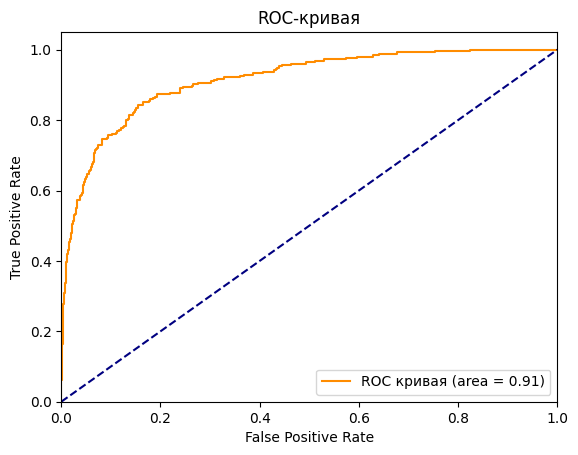

ROC_AUC Метрика:  0.9131890737702784


In [ ]:
fpr, tpr, treshold = roc_curve(y_test, pred_proba_up)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()
print('ROC_AUC Метрика: ',roc_auc_score(y_test, pred_proba_up))

# 4. Вывод

В процессе работы были проведены множественные этапы анализа и обработки данных для построения модели классификации. Были применены различные техники предобработки, включая добавление новых признаков, объединение датасетов и заполнение пропущенных значений.

После этого был проведен исследовательский анализ данных, на котором были выявлены особенности датасета и определены ключевые факторы, влияющие на целевую переменную.

Затем данные были подготовлены к обучению путем разделения на несколько выборок, кодирования признаков и маштабирования. Было проведено также визуальное и численное оценивание влияния каждого признака на модель.

Были обучены три модели: RandomForestClassifier, LogisticRegression и CatBosstClassifier. Наилучшие результаты показала модель CatBoostClassifier с метрикой ROC_AUC = 0.91

Таким образом, в ходе работы была построена эффективная модель классификации с использованием различных техник анализа данных и машинного обучения.

# Отчёт

## Параметры для воспроизводства лучшей модели CatBoostClassifier

По итогам проделанной работы лучшие результаты  показала модель CatBoostClassifier, данные для её обучения приведены ниже.

Набор признаков для обучения состоял из: 'MonthlyCharges', 'TotalCharges', 'Period', 'SeniorCitizen',
       'Type_Month-to-month', 'Type_One year', 'Type_Two year',
       'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes',
       'Internet_1.0', 'Internet_No', 'MultipleLines_No', 'MultipleLines_Yes',
       'Phone_1.0', 'Phone_No'

размер тестовой выборки: test_size=0.25, random_state= 220523

Лучшие  гиперпараметры обученной модели CatBoostClassifier: {'depth': 6, 'iterations': 300, 'learning_rate': 0.1}

## Ход выполнения работы

В процессе работы были проведены множественные этапы анализа и обработки данных для построения модели классификации. Были применены различные техники предобработки, включая добавление новых признаков, объединение датасетов и заполнение пропущенных значений.
План выполнения работ состоял из следующих пунктов:

1.2 Описание услуг

2. Загрузка данных и предварительный анализ

2.1 Загрузка данных и библиотек

2.1 Предварительный анализ данных

2.2 Объеденение данных и генерация признаков

3. Исследовательский анализ данных и подготовка данных для обучения моделей

3.1 Исследовательский анализ данных

3.2 Подготовка данных для обучения моделей

3.3 Обучение моделей

3.4 Проверка на тестовой выборке


Был проведен исследовательский анализ данных, на котором были выявлены особенности датасета и определены ключевые факторы, влияющие на целевую переменную.

С помощью кореляции Пирсона было выяснено, что основными из этих признаков являются:
Period - какой срок клиент пользуеться услугами

MonthlyCharges - Размер ежемесечного платежа

TotalCharges - Общая сумма за весь срок пользования услугами заказчика

Корреляция между этими признаками может быть описана следующим образом: с увеличением периода пользования услугами увеличивается и общая сумма, которую клиент заплатил за весь период. Кроме того, часто можно заметить, что размер ежемесячного платежа также связан с общей суммой и периодом пользования услугами - например, если клиент платит больше каждый месяц, то общая сумма за весь период вероятно будет выше. Эти признаки можно использовать для анализа поведения клиентов и принятия решений в бизнесе.

Затем данные были подготовлены к обучению путем разделения на несколько выборок, кодирования признаков и масштабирования. Было проведено также визуальное и численное оценивание влияния каждого признака на модель.

Были обучены три модели: RandomForestClassifier, LogisticRegression и CatBosstClassifier. Наилучшие результаты показала модель CatBoostClassifier с метрикой ROC_AUC = 0.91

Таким образом, в ходе работы была построена эффективная модель классификации с использованием различных техник анализа данных и машинного обучения.

В ходе выполнения работы возникли следующте затруднения:

Был выбран неправльный способ анализа корреляции основных признаков исправлено с помощью применения корреляции Пирсона

Были затруднения с кодированием признаков, возможно нужно было попробовать другие методы кодирования в сочетании с применением pipeline

Все шаги из плана работ были выполнены